<a href="https://colab.research.google.com/github/orlandoddi/Lectura-de-ECG-/blob/main/codigo_corregido_v16GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Instalación de dependencias
!pip install wfdb scipy numpy tensorflow scikit-learn matplotlib imblearn seaborn -q

import numpy as np
import wfdb
from scipy.signal import resample, butter, filtfilt, iirnotch
from sklearn.preprocessing import LabelEncoder, label_binarize
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Input, UpSampling1D
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix
from imblearn.over_sampling import SMOTE  # ✅ Cambio: usar SMOTE en lugar de undersampling
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from itertools import cycle
import time
import warnings
warnings.filterwarnings("ignore")

print("✅ Librerías importadas correctamente")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.9/163.9 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 57.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 3.0.0 which is incompatible.
dask-cudf-cu12 25.10.0 requires pandas<2.4.0dev0,>=2.0, but you have pandas 3.0.0 which is incompatible.
cudf-cu12 25.10.0 requires pandas<2.4.0dev0,>=2.0, but you have pandas 3.0.0 which is incompatible.
db-dtypes 1.5.0 requires pandas<3.0.0,>=1.5.3, but you have pandas 3.0.0 which is incompatible.
bqplot 0.12.45 requires pandas<3.0.0,>=1.0.0, but you have pandas 3.0.0 which is incompatible.
gradio 5.50.0 requires pandas<3.0,>=1.0, but you have pandas 3.0.0 which is incompatible.
✅ Librer

In [ ]:
# ============================================================
# FUNCIONES DE PREPROCESAMIENTO
# ============================================================

def filtro_pasa_banda(senal, fs, lowcut=0.5, highcut=40.0, orden=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(orden, [low, high], btype='band')
    return filtfilt(b, a, senal)

def filtro_notch(senal, fs, freq_notch=60.0, Q=30.0):
    w0 = freq_notch / (fs / 2)
    b, a = iirnotch(w0, Q)
    return filtfilt(b, a, senal)

def normalizar_segmento(segmento):
    min_val = np.min(segmento)
    max_val = np.max(segmento)
    if max_val == min_val:
        return segmento - min_val
    return (segmento - min_val) / (max_val - min_val)

def ajustar_frecuencia(senal, frecuencia_original, frecuencia_deseada=360):
    if frecuencia_original == frecuencia_deseada:
        return senal
    num_muestras_nuevo = int(len(senal) * frecuencia_deseada / frecuencia_original)
    return resample(senal, num_muestras_nuevo)

def segmentar_y_normalizar(senal, picos, tamano_ventana=256):
    segmentos = []
    indices_validos = []
    for i, pico in enumerate(picos):
        inicio = pico - tamano_ventana // 2
        fin = pico + tamano_ventana // 2
        if inicio >= 0 and fin <= len(senal):
            segmento = senal[inicio:fin]
            if len(segmento) == tamano_ventana:
                segmento_norm = normalizar_segmento(segmento)
                segmentos.append(segmento_norm)
                indices_validos.append(i)
    return np.array(segmentos), indices_validos

print("✅ Funciones de preprocesamiento definidas")

✅ Funciones de preprocesamiento definidas


In [ ]:
# ============================================================
# CARGAR Y PROCESAR MIT-BIH
# ============================================================

print("\n" + "="*70)
print("CARGA Y PREPROCESAMIENTO DE DATOS MIT-BIH")
print("="*70)

registros = [str(i) for i in range(100, 235)]
segmentos_total = []
etiquetas_total = []
frecuencia_mit = 360

for idx, reg in enumerate(registros, 1):
    try:
        print(f"[{idx}/{len(registros)}] Procesando registro {reg}...", end=' ')
        record_mit = wfdb.rdrecord(reg, pn_dir='mitdb/')
        annotation_mit = wfdb.rdann(reg, extension='atr', pn_dir='mitdb/')
        senal_mit = record_mit.p_signal[:, 0]
        picos_mit = annotation_mit.sample
        etiquetas_mit = annotation_mit.symbol

        senal_mit_ajustada = ajustar_frecuencia(senal_mit, frecuencia_mit)
        senal_mit_filtrada = filtro_pasa_banda(senal_mit_ajustada, fs=frecuencia_mit)
        senal_mit_filtrada = filtro_notch(senal_mit_filtrada, fs=frecuencia_mit)

        segmentos_reg, indices_validos = segmentar_y_normalizar(senal_mit_filtrada, picos_mit)
        etiquetas_reg = [etiquetas_mit[i] for i in indices_validos]

        segmentos_total.extend(segmentos_reg)
        etiquetas_total.extend(etiquetas_reg)
        print(f"✓ {len(segmentos_reg)} segmentos")
    except Exception as e:
        print(f"✗ Error: {str(e)}")
        continue

segmentos_total = np.array(segmentos_total)
etiquetas_total = np.array(etiquetas_total)

print(f"\n{'='*70}")
print(f"✅ Total de segmentos procesados: {len(segmentos_total):,}")
print(f"{'='*70}")


CARGA Y PREPROCESAMIENTO DE DATOS MIT-BIH
[1/135] Procesando registro 100... ✓ 2271 segmentos
[2/135] Procesando registro 101... ✓ 1872 segmentos
[3/135] Procesando registro 102... ✓ 2191 segmentos
[4/135] Procesando registro 103... ✓ 2089 segmentos
[5/135] Procesando registro 104... ✓ 2308 segmentos
[6/135] Procesando registro 105... ✓ 2690 segmentos
[7/135] Procesando registro 106... ✓ 2097 segmentos
[8/135] Procesando registro 107... ✓ 2138 segmentos
[9/135] Procesando registro 108... ✓ 1822 segmentos
[10/135] Procesando registro 109... ✓ 2532 segmentos
[11/135] Procesando registro 110... ✗ Error: 404 Error: Not Found for url: https://physionet.org/files/mitdb/1.0.0/110.hea
[12/135] Procesando registro 111... ✓ 2132 segmentos
[13/135] Procesando registro 112... ✓ 2547 segmentos
[14/135] Procesando registro 113... ✓ 1794 segmentos
[15/135] Procesando registro 114... ✓ 1889 segmentos
[16/135] Procesando registro 115... ✓ 1960 segmentos
[17/135] Procesando registro 116... ✓ 2420 segme

In [ ]:
# ============================================================
# ETIQUETADO AAMI Y CODIFICACIÓN
# ============================================================

print("\n" + "="*70)
print("ETIQUETADO AAMI")
print("="*70)

mapeo_aami = {
    'N': 'N', 'L': 'N', 'R': 'N',
    'A': 'S', 'S': 'S', 'J': 'S',
    'V': 'V', 'E': 'V',
    'F': 'F',
    'Q': 'Q', 'f': 'Q', '/': 'Q', '+': 'Q'
}

etiquetas_aami = [mapeo_aami.get(e, 'Q') for e in etiquetas_total]

print("\nDistribución de clases AAMI:")
class_dist = Counter(etiquetas_aami)
total = sum(class_dist.values())
for clase in sorted(class_dist.keys()):
    cantidad = class_dist[clase]
    pct = (cantidad/total)*100
    print(f"  {clase}: {cantidad:>7,} ({pct:>5.2f}%)")

# Codificar etiquetas
codificador = LabelEncoder()
etiquetas_numeros = codificador.fit_transform(etiquetas_aami)
etiquetas_onehot = to_categorical(etiquetas_numeros)

print(f"\n✅ Etiquetas codificadas: {len(codificador.classes_)} clases")
print(f"   Clases: {list(codificador.classes_)}")
print("="*70)


ETIQUETADO AAMI

Distribución de clases AAMI:
  F:     802 ( 0.71%)
  N:  90,348 (80.27%)
  Q:  11,542 (10.25%)
  S:   2,631 ( 2.34%)
  V:   7,235 ( 6.43%)

✅ Etiquetas codificadas: 5 clases
   Clases: [np.str_('F'), np.str_('N'), np.str_('Q'), np.str_('S'), np.str_('V')]


In [ ]:
# ============================================================
# DIVISIÓN INICIAL: 70% TRAIN-VAL / 15% TEST / 15% (reservado para AE)
# ============================================================

print("\n" + "="*70)
print("DIVISIÓN DE DATOS (70/15/15)")
print("="*70)

# Preparar datos para autoencoder
X_auto = segmentos_total[..., np.newaxis]

# PASO 1: Separar conjunto de TEST (15%)
X_trainval, X_test_auto, y_trainval, y_test_temp, idx_trainval, idx_test = train_test_split(
    X_auto, etiquetas_onehot, np.arange(len(X_auto)),
    test_size=0.15,
    random_state=42,
    stratify=etiquetas_numeros
)

# Extraer etiquetas numéricas para segundo split
y_trainval_numeros = np.argmax(y_trainval, axis=1)

# PASO 2: Dividir Train-Val en TRAIN (70%) y VAL (15%)
# De los 85% restantes: 70/85 ≈ 82.35% train, 15/85 ≈ 17.65% val
X_train_auto, X_val_auto, y_train_temp, y_val_temp = train_test_split(
    X_trainval, y_trainval,
    test_size=0.176,  # 15% del total
    random_state=42,
    stratify=y_trainval_numeros
)

total_samples = len(X_auto)
print(f"\nTotal de muestras: {total_samples:,}")
print(f"\nEntrenamiento: {len(X_train_auto):>7,} ({len(X_train_auto)/total_samples*100:.1f}%)")
print(f"Validación:    {len(X_val_auto):>7,} ({len(X_val_auto)/total_samples*100:.1f}%)")
print(f"Prueba:        {len(X_test_auto):>7,} ({len(X_test_auto)/total_samples*100:.1f}%)")
print("="*70)

print("\n✅ División triple completada correctamente")


DIVISIÓN DE DATOS (70/15/15)

Total de muestras: 112,558

Entrenamiento:  78,835 (70.0%)
Validación:     16,839 (15.0%)
Prueba:         16,884 (15.0%)

✅ División triple completada correctamente



CONSTRUCCIÓN DEL AUTOENCODER

📋 Arquitectura del Autoencoder:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 256, 32)        │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 128, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 128, 16)        │         2,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 64, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 64, 16)         │         1,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d (UpSampling1D)    │ (None, 128, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 128, 32)        │         2,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_1 (UpSampling1D)  │ (None, 256, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 256, 1)         │            97 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,753 (26.38 KB)

 Trainable params: 6,753 (26.38 KB)

 Non-trainable params: 0 (0.00 B)


📋 Arquitectura del Encoder:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 256, 32)        │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 128, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 128, 16)        │         2,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 64, 16)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,768 (10.81 KB)

 Trainable params: 2,768 (10.81 KB)

 Non-trainable params: 0 (0.00 B)


ENTRENAMIENTO DEL AUTOENCODER

⏳ Iniciando entrenamiento...
Epoch 1/20
2464/2464 ━━━━━━━━━━━━━━━━━━━━ 26s 7ms/step - loss: 0.0027 - val_loss: 2.4468e-05
Epoch 2/20
2464/2464 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - loss: 1.2424e-05 - val_loss: 5.2688e-06
Epoch 3/20
2464/2464 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 1.0089e-05 - val_loss: 4.2682e-06
Epoch 4/20
2464/2464 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 6.4747e-06 - val_loss: 2.8534e-06
Epoch 5/20
2464/2464 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 4.5019e-06 - val_loss: 1.9131e-06
Epoch 6/20
2464/2464 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 3.2919e-06 - val_loss: 5.3721e-06
Epoch 7/20
2464/2464 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 4.4717e-06 - val_loss: 1.0741e-06
Epoch 8/20
2464/2464 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 4.7624e-06 - val_loss: 9.8835e-07
Epoch 9/20
2464/2464 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 2.7050e-06 - val_loss: 4.9003e-06
Epoch 10/20
2464/2464 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 3.3673e-06 - 

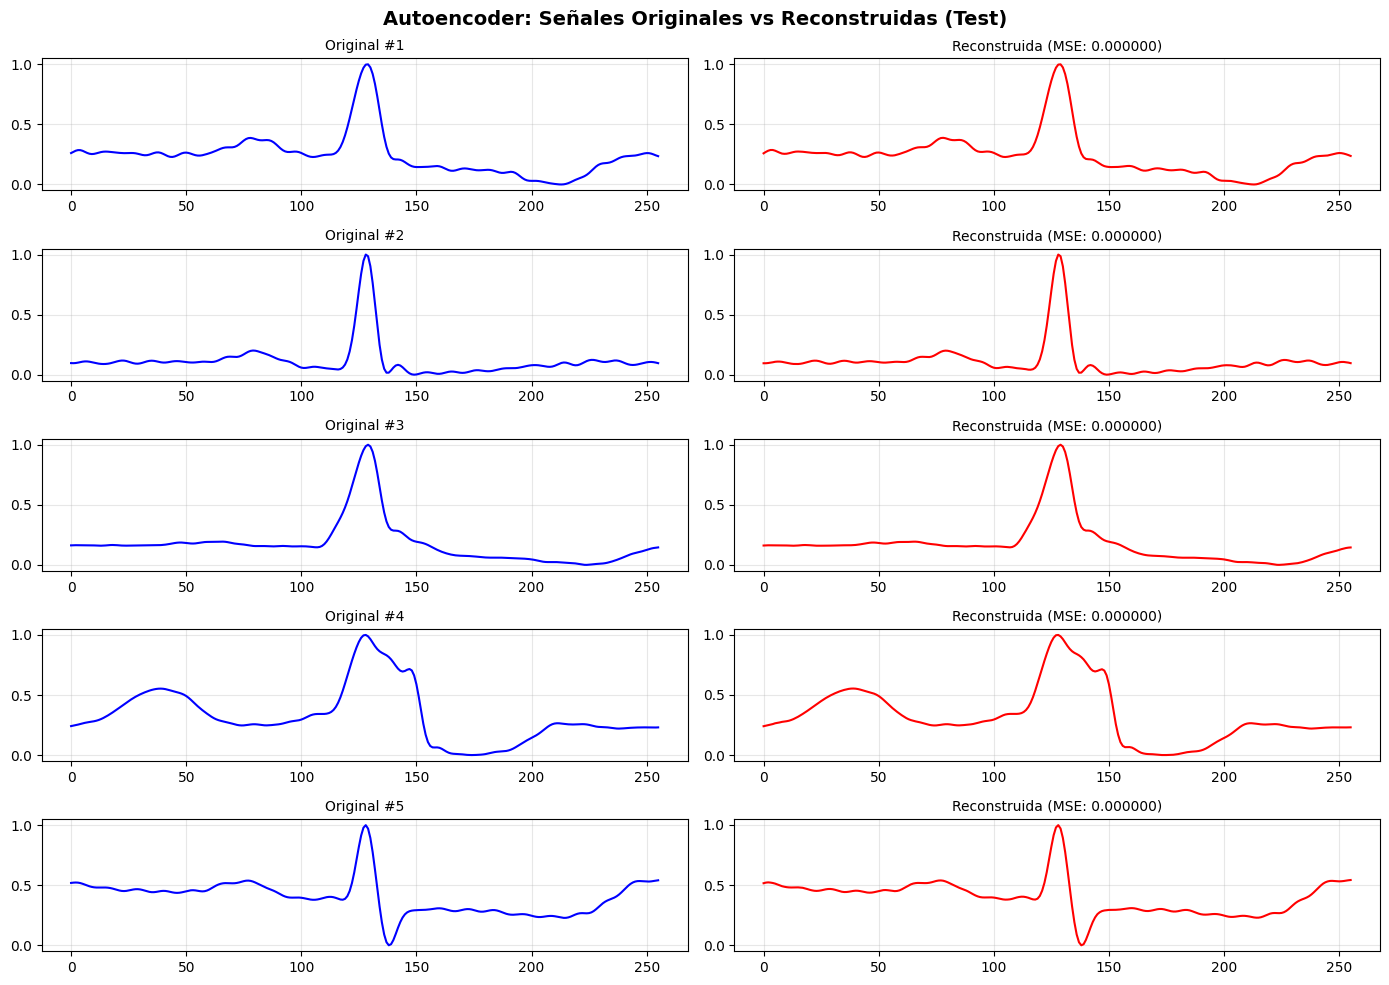

In [ ]:
# ============================================================
# AUTOENCODER - DEFINICIÓN Y ENTRENAMIENTO
# ============================================================

print("\n" + "="*70)
print("CONSTRUCCIÓN DEL AUTOENCODER")
print("="*70)

input_shape = (256, 1)
input_signal = Input(shape=input_shape)

# Encoder
x = Conv1D(32, kernel_size=5, activation='relu', padding='same')(input_signal)
x = MaxPooling1D(pool_size=2)(x)
x = Conv1D(16, kernel_size=5, activation='relu', padding='same')(x)
encoded = MaxPooling1D(pool_size=2)(x)

# Decoder
x = Conv1D(16, kernel_size=5, activation='relu', padding='same')(encoded)
x = UpSampling1D(size=2)(x)
x = Conv1D(32, kernel_size=5, activation='relu', padding='same')(x)
x = UpSampling1D(size=2)(x)
decoded = Conv1D(1, kernel_size=3, activation='linear', padding='same')(x)

# Modelos
autoencoder = Model(input_signal, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
encoder = Model(input_signal, encoded)

print("\n📋 Arquitectura del Autoencoder:")
autoencoder.summary()

print("\n📋 Arquitectura del Encoder:")
encoder.summary()

# ============================================================
# ENTRENAR AUTOENCODER
# ============================================================

print("\n" + "="*70)
print("ENTRENAMIENTO DEL AUTOENCODER")
print("="*70)

print("\n⏳ Iniciando entrenamiento...")
start_time = time.time()

historia_ae = autoencoder.fit(
    X_train_auto, X_train_auto,
    epochs=20,
    batch_size=32,
    validation_data=(X_val_auto, X_val_auto),  # ✅ Validación separada
    verbose=1
)

tiempo_ae = time.time() - start_time

print(f"\n✅ Autoencoder entrenado en {tiempo_ae:.2f}s ({tiempo_ae/60:.2f} min)")

# ============================================================
# EVALUAR AUTOENCODER EN TEST
# ============================================================

print("\n" + "="*70)
print("EVALUACIÓN DEL AUTOENCODER - CONJUNTO DE PRUEBA")
print("="*70)

# Calcular MSE en test
mse_test = autoencoder.evaluate(X_test_auto, X_test_auto, verbose=0)

print(f"\n📊 MSE en Test: {mse_test:.6f}")

# Visualizar reconstrucciones
num_ejemplos = 5
indices_ejemplos = np.random.choice(len(X_test_auto), size=num_ejemplos, replace=False)
X_ejemplos = X_test_auto[indices_ejemplos]
X_reconstruidas = autoencoder.predict(X_ejemplos, verbose=0)

fig, axes = plt.subplots(num_ejemplos, 2, figsize=(14, 10))
fig.suptitle('Autoencoder: Señales Originales vs Reconstruidas (Test)', fontsize=14, fontweight='bold')

for i in range(num_ejemplos):
    mse_sample = np.mean((X_ejemplos[i] - X_reconstruidas[i])**2)

    axes[i, 0].plot(X_ejemplos[i].squeeze(), 'b-', linewidth=1.5)
    axes[i, 0].set_title(f'Original #{i+1}', fontsize=10)
    axes[i, 0].grid(True, alpha=0.3)

    axes[i, 1].plot(X_reconstruidas[i].squeeze(), 'r-', linewidth=1.5)
    axes[i, 1].set_title(f'Reconstruida (MSE: {mse_sample:.6f})', fontsize=10)
    axes[i, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/content/autoencoder_reconstrucciones.png', dpi=150)
print("\n✅ Gráfica guardada: autoencoder_reconstrucciones.png")
plt.show()

print("="*70)

In [ ]:
# ============================================================
# EXTRACCIÓN DE CARACTERÍSTICAS CON ENCODER
# ============================================================

print("\n" + "="*70)
print("EXTRACCIÓN DE CARACTERÍSTICAS")
print("="*70)

print("\n⏳ Aplicando encoder a cada conjunto...")

X_train_encoded = encoder.predict(X_train_auto, verbose=0)
X_val_encoded = encoder.predict(X_val_auto, verbose=0)
X_test_encoded = encoder.predict(X_test_auto, verbose=0)

print(f"\n✅ Features extraídas:")
print(f"   Train: {X_train_encoded.shape}")
print(f"   Val:   {X_val_encoded.shape}")
print(f"   Test:  {X_test_encoded.shape}")
print("="*70)


EXTRACCIÓN DE CARACTERÍSTICAS

⏳ Aplicando encoder a cada conjunto...

✅ Features extraídas:
   Train: (78835, 64, 16)
   Val:   (16839, 64, 16)
   Test:  (16884, 64, 16)


In [ ]:
# ============================================================
# BALANCEO CON SMOTE SELECTIVO (30%)
# ============================================================

print("\n" + "="*70)
print("BALANCEO DE CLASES - SMOTE SELECTIVO")
print("="*70)

# Aplanar para SMOTE
X_train_flat = X_train_encoded.reshape(X_train_encoded.shape[0], -1)
y_train_labels = np.argmax(y_train_temp, axis=1)

# Distribución ANTES
print("\n📊 Distribución ANTES del balanceo:")
count_antes = Counter(y_train_labels)
total_antes = sum(count_antes.values())
for clase in sorted(count_antes.keys()):
    nombre = codificador.classes_[clase]
    cantidad = count_antes[clase]
    pct = (cantidad/total_antes)*100
    print(f"  {nombre}: {cantidad:>6,} ({pct:>5.2f}%)")

# Estrategia SMOTE: 30% de la mayoritaria
max_count = max(count_antes.values())
threshold = int(max_count * 0.30)

print(f"\n🎯 Umbral (30% de {max_count:,}): {threshold:,} muestras")

sampling_strategy = {}
for clase, count in count_antes.items():
    if count < threshold:
        sampling_strategy[clase] = threshold

if sampling_strategy:
    print("\n⏳ Aplicando SMOTE...")
    smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42, k_neighbors=5)
    X_train_balanced_flat, y_train_balanced = smote.fit_resample(X_train_flat, y_train_labels)

    # Reshape de vuelta
    X_train_balanced = X_train_balanced_flat.reshape(
        X_train_balanced_flat.shape[0],
        X_train_encoded.shape[1],
        X_train_encoded.shape[2]
    )

    y_train_balanced_onehot = to_categorical(y_train_balanced, num_classes=len(codificador.classes_))

    print("\n📊 Distribución DESPUÉS del balanceo:")
    count_despues = Counter(y_train_balanced)
    total_despues = sum(count_despues.values())
    for clase in sorted(count_despues.keys()):
        nombre = codificador.classes_[clase]
        cantidad = count_despues[clase]
        pct = (cantidad/total_despues)*100
        cambio = cantidad - count_antes[clase]
        print(f"  {nombre}: {cantidad:>6,} ({pct:>5.2f}%) [{cambio:>+6,}]")

    print(f"\n✅ Incremento: +{total_despues - total_antes:,} muestras sintéticas")
else:
    print("\n⚠️  No se requiere SMOTE (clases ya balanceadas)")
    X_train_balanced = X_train_encoded
    y_train_balanced_onehot = y_train_temp

print("="*70)


BALANCEO DE CLASES - SMOTE SELECTIVO

📊 Distribución ANTES del balanceo:
  F:    562 ( 0.71%)
  N: 63,279 (80.27%)
  Q:  8,084 (10.25%)
  S:  1,842 ( 2.34%)
  V:  5,068 ( 6.43%)

🎯 Umbral (30% de 63,279): 18,983 muestras

⏳ Aplicando SMOTE...

📊 Distribución DESPUÉS del balanceo:
  F: 18,983 (13.64%) [+18,421]
  N: 63,279 (45.46%) [    +0]
  Q: 18,983 (13.64%) [+10,899]
  S: 18,983 (13.64%) [+17,141]
  V: 18,983 (13.64%) [+13,915]

✅ Incremento: +60,376 muestras sintéticas


In [ ]:
# ============================================================
# CLASIFICADOR CNN-LSTM
# ============================================================

print("\n" + "="*70)
print("CONSTRUCCIÓN DEL CLASIFICADOR CNN-LSTM")
print("="*70)

modelo_hibrido = Sequential([
    Conv1D(32, kernel_size=5, activation='relu',
           input_shape=(X_train_encoded.shape[1], X_train_encoded.shape[2])),
    MaxPooling1D(pool_size=2),
    Conv1D(64, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    LSTM(128, return_sequences=False),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(codificador.classes_), activation='softmax')
])

modelo_hibrido.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print("\n📋 Arquitectura del Clasificador:")
modelo_hibrido.summary()

# ============================================================
# ENTRENAR CLASIFICADOR
# ============================================================

print("\n" + "="*70)
print("ENTRENAMIENTO DEL CLASIFICADOR")
print("="*70)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

print("\n⏳ Iniciando entrenamiento...")
start_time = time.time()

historia = modelo_hibrido.fit(
    X_train_balanced, y_train_balanced_onehot,
    epochs=50,
    batch_size=32,
    validation_data=(X_val_encoded, y_val_temp),  # ✅ Validación separada
    callbacks=[early_stopping],
    verbose=1
)

tiempo_clf = time.time() - start_time

print(f"\n✅ Clasificador entrenado en {tiempo_clf:.2f}s ({tiempo_clf/60:.2f} min)")
print("="*70)


CONSTRUCCIÓN DEL CLASIFICADOR CNN-LSTM

📋 Arquitectura del Clasificador:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_5 (Conv1D)               │ (None, 60, 32)         │         2,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 30, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 26, 64)         │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 13, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 128,869 (503.39 KB)

 Trainable params: 128,869 (503.39 KB)

 Non-trainable params: 0 (0.00 B)


ENTRENAMIENTO DEL CLASIFICADOR

⏳ Iniciando entrenamiento...
Epoch 1/50
4351/4351 ━━━━━━━━━━━━━━━━━━━━ 38s 8ms/step - accuracy: 0.7587 - loss: 0.6298 - val_accuracy: 0.9449 - val_loss: 0.1710
Epoch 2/50
4351/4351 ━━━━━━━━━━━━━━━━━━━━ 33s 8ms/step - accuracy: 0.9503 - loss: 0.1527 - val_accuracy: 0.9628 - val_loss: 0.1249
Epoch 3/50
4351/4351 ━━━━━━━━━━━━━━━━━━━━ 41s 8ms/step - accuracy: 0.9700 - loss: 0.0937 - val_accuracy: 0.9759 - val_loss: 0.0761
Epoch 4/50
4351/4351 ━━━━━━━━━━━━━━━━━━━━ 34s 8ms/step - accuracy: 0.9783 - loss: 0.0681 - val_accuracy: 0.9813 - val_loss: 0.0664
Epoch 5/50
4351/4351 ━━━━━━━━━━━━━━━━━━━━ 33s 8ms/step - accuracy: 0.9823 - loss: 0.0544 - val_accuracy: 0.9818 - val_loss: 0.0616
Epoch 6/50
4351/4351 ━━━━━━━━━━━━━━━━━━━━ 34s 8ms/step - accuracy: 0.9854 - loss: 0.0459 - val_accuracy: 0.9825 - val_loss: 0.0608
Epoch 7/50
4351/4351 ━━━━━━━━━━━━━━━━━━━━ 33s 8ms/step - accuracy: 0.9879 - loss: 0.0386 - val_accuracy: 0.9851 - val_loss: 0.0579
Epoch 8/50
4351/4351 

✅ Gráfica guardada: entrenamiento.png


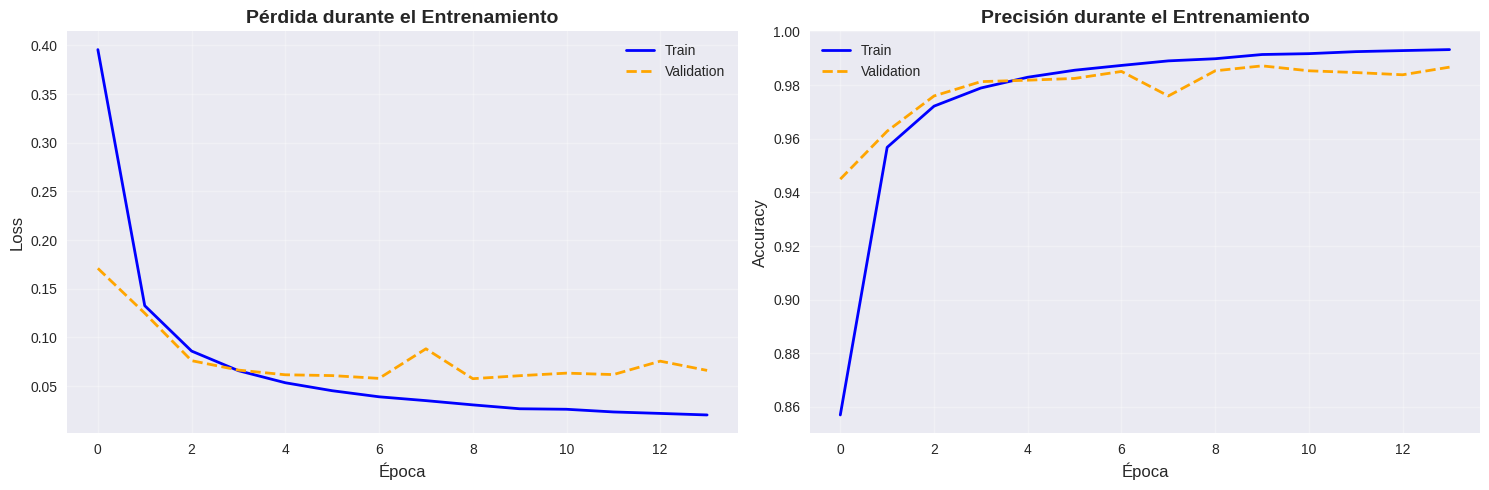

In [ ]:
# ============================================================
# GRÁFICAS DE ENTRENAMIENTO
# ============================================================

plt.style.use('seaborn-v0_8')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Pérdida
ax1.plot(historia.history['loss'], label='Train', color='blue', linewidth=2)
ax1.plot(historia.history['val_loss'], label='Validation', color='orange', linestyle='--', linewidth=2)
ax1.set_title('Pérdida durante el Entrenamiento', fontsize=14, fontweight='bold')
ax1.set_xlabel('Época', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Precisión
ax2.plot(historia.history['accuracy'], label='Train', color='blue', linewidth=2)
ax2.plot(historia.history['val_accuracy'], label='Validation', color='orange', linestyle='--', linewidth=2)
ax2.set_title('Precisión durante el Entrenamiento', fontsize=14, fontweight='bold')
ax2.set_xlabel('Época', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/content/entrenamiento.png', dpi=150)
print("✅ Gráfica guardada: entrenamiento.png")
plt.show()


EVALUACIÓN FINAL - CONJUNTO DE PRUEBA

📊 Classification Report:
              precision    recall  f1-score   support

           F       0.72      0.88      0.79       120
           N       0.99      0.99      0.99     13553
           Q       0.98      0.98      0.98      1731
           S       0.88      0.92      0.90       395
           V       0.97      0.96      0.96      1085

    accuracy                           0.99     16884
   macro avg       0.91      0.95      0.93     16884
weighted avg       0.99      0.99      0.99     16884


✅ Gráfica guardada: matriz_confusion.png


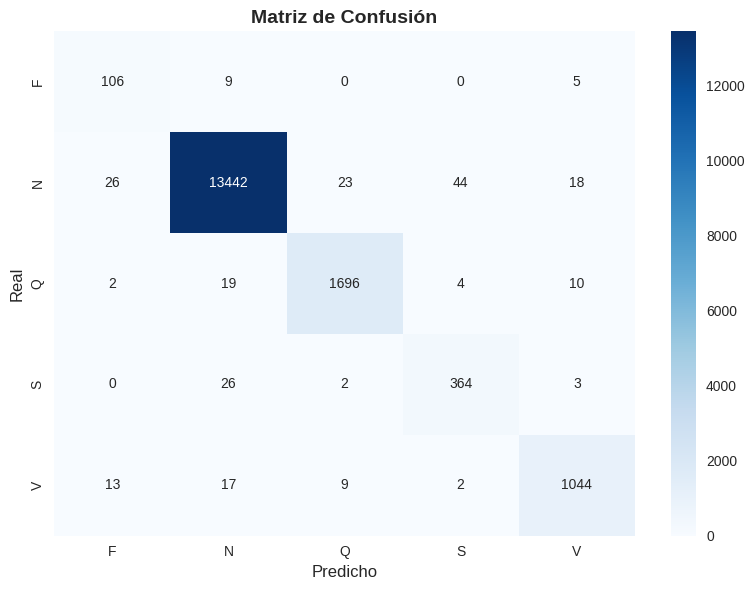

In [ ]:
# ============================================================
# EVALUACIÓN FINAL EN CONJUNTO DE PRUEBA
# ============================================================

print("\n" + "="*70)
print("EVALUACIÓN FINAL - CONJUNTO DE PRUEBA")
print("="*70)

# Predicciones
y_pred = modelo_hibrido.predict(X_test_encoded, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test_temp, axis=1)

# Classification Report
print("\n📊 Classification Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=codificador.classes_))

# Matriz de Confusión
cm = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=codificador.classes_, yticklabels=codificador.classes_)
plt.title('Matriz de Confusión', fontsize=14, fontweight='bold')
plt.xlabel('Predicho', fontsize=12)
plt.ylabel('Real', fontsize=12)
plt.tight_layout()
plt.savefig('/content/matriz_confusion.png', dpi=150)
print("\n✅ Gráfica guardada: matriz_confusion.png")
plt.show()

print("="*70)


CURVAS ROC
  AUC F: 0.9981
  AUC N: 0.9985
  AUC Q: 0.9992
  AUC S: 0.9974
  AUC V: 0.9996

  AUC Macro: 0.9986

✅ Gráfica guardada: curvas_roc.png


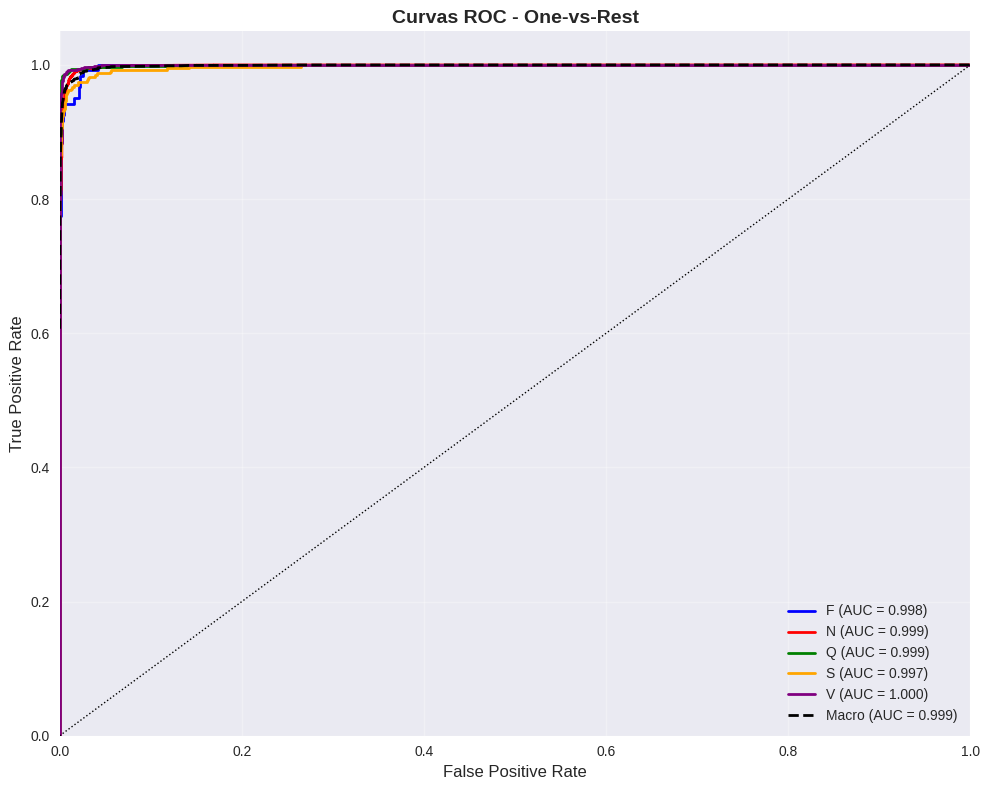

In [ ]:
# ============================================================
# CURVAS ROC
# ============================================================

print("\n" + "="*70)
print("CURVAS ROC")
print("="*70)

present_classes = np.unique(y_test_classes)
y_test_bin = label_binarize(y_test_classes, classes=present_classes)
y_pred_present = y_pred[:, present_classes]

fpr, tpr, roc_auc = {}, {}, {}

for i, cls_idx in enumerate(present_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_present[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    print(f"  AUC {codificador.classes_[cls_idx]}: {roc_auc[i]:.4f}")

# AUC Macro
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(present_classes))]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(present_classes)):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= len(present_classes)
roc_auc_macro = auc(all_fpr, mean_tpr)
print(f"\n  AUC Macro: {roc_auc_macro:.4f}")

# Graficar
plt.figure(figsize=(10, 8))
colors = cycle(['blue', 'red', 'green', 'orange', 'purple'])

for i, color in zip(range(len(present_classes)), colors):
    cls_name = codificador.classes_[present_classes[i]]
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{cls_name} (AUC = {roc_auc[i]:.3f})')

plt.plot(all_fpr, mean_tpr, 'k--', lw=2,
         label=f'Macro (AUC = {roc_auc_macro:.3f})')
plt.plot([0, 1], [0, 1], 'k:', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Curvas ROC - One-vs-Rest', fontsize=14, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('/content/curvas_roc.png', dpi=150)
print("\n✅ Gráfica guardada: curvas_roc.png")
plt.show()

print("="*70)

In [ ]:
# ============================================================
# REPORTE DE TIEMPOS
# ============================================================

print("\n" + "="*70)
print("⏱️  REPORTE DE TIEMPOS DE EJECUCIÓN")
print("="*70)
print(f"\nAutoencoder:  {tiempo_ae:>8.2f}s ({tiempo_ae/60:>6.2f} min)")
print(f"Clasificador: {tiempo_clf:>8.2f}s ({tiempo_clf/60:>6.2f} min)")
print(f"{'─'*70}")
print(f"TOTAL:        {tiempo_ae + tiempo_clf:>8.2f}s ({(tiempo_ae + tiempo_clf)/60:>6.2f} min)")
print("="*70)

print("\n✅ ¡Proceso completado exitosamente!")


⏱️  REPORTE DE TIEMPOS DE EJECUCIÓN

Autoencoder:    205.49s (  3.42 min)
Clasificador:   496.71s (  8.28 min)
──────────────────────────────────────────────────────────────────────
TOTAL:          702.20s ( 11.70 min)

✅ ¡Proceso completado exitosamente!
